# **Sentiment Analysis on Queen Elizabeth’s Death: Tweets from Around the World on Queen Elizabeth II.**

## This notebook contains experiments using a simple keyword-based heuristic to assign sentiment labels and then training a supervised logistic regression model.

## Setting up pyspark, hadoop and java

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar -xvf spark-3.5.3-bin-hadoop3.tgz
!pip install findspark

--2024-12-16 03:11:57--  https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400864419 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.3-bin-hadoop3.tgz’

spark-3.5.3-bin-had 100%[===================>] 382.29M  15.0MB/s    in 29s     

2024-12-16 03:12:26 (13.4 MB/s) - ‘spark-3.5.3-bin-hadoop3.tgz’ saved [400864419/400864419]

spark-3.5.3-bin-hadoop3/
spark-3.5.3-bin-hadoop3/data/
spark-3.5.3-bin-hadoop3/data/graphx/
spark-3.5.3-bin-hadoop3/data/graphx/users.txt
spark-3.5.3-bin-hadoop3/data/graphx/followers.txt
spark-3.5.3-bin-hadoop3/data/mllib/
spark-3.5.3-bin-hadoop3/data/mllib/sample_linear_regression_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_fpgrowth.txt
spark-3.5.3-bin-hadoop3/data/mllib/sam


## Setting up Kaggle and Importing Data about Tweets on Queen Elizabeth's Death

In [ ]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aneeshtickoo/tweets-after-queen-elizabeth-iis-death")

print("Path to dataset files:", path)

100%|██████████| 28.4M/28.4M [00:02<00:00, 11.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aneeshtickoo/tweets-after-queen-elizabeth-iis-death/versions/1


## Creating Spark Session

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Sentiment_Analysis_of_the_death_of_Queen_Elizabeth")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()


## Reading the Dataset

In [ ]:
file_path = f"{path}/queen.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()
df.show(5, truncate=False)

root
 |-- id: string (nullable = true)
 |-- conversation_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- username: string (nullable = true)
 |-- name: string (nullable = true)
 |-- place: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- language: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- urls: string (nullable = true)
 |-- photos: string (nullable = true)
 |-- replies_count: string (nullable = true)
 |-- retweets_count: string (nullable = true)
 |-- likes_count: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- cashtags: string (nullable = true)
 |-- link: string (nullable = true)
 |-- retweet: string (nullable = true)
 |-- quote_url: string (nullable = true)
 |-- video: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- near: 

## Cleaning/Processing Data
Tokenizing and removing stop words.

In [ ]:
#importing required libraries for preprocessing data
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# remove rows with empty tweet
df = df.na.drop(subset=["tweet"])

# splitting up tweet sentences into words.
tokenizer = Tokenizer(inputCol="tweet", outputCol="wordsOnly")
tokenized_df = tokenizer.transform(df)

# Removing unimportant words from the column "words" created above. Un important words like 'a', 'the', 'an',etc are removed.
remover = StopWordsRemover(inputCol="wordsOnly", outputCol="filteredWords")
preprocessed_df = remover.transform(tokenized_df)

# Showing df after the above changes
preprocessed_df.show(5, truncate=False)


+-------------------+-------------------+---------------------------------------+----------+--------+--------+------------------+----------+---------------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------+---------------------------------------------------+-------------+---------------------------------------------------+-----------+--------+--------+---------------------------------------------------------+-------+----------------

## Sentiment Labelling
Using a simple keyword-based heuristic to assign sentiment labels.

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

def sentiment_analysis(words):
    positive_words = ["love", "condolences", "grateful", "respect", "admire", "support"]
    negative_words = ["hate", "criticize", "anger", "disrespect", "colonial", "resentment"]
    mourning_words = ["passed away", "mourning", "sad", "loss", "grieve"]

    # Ensure words is a list (from filtered_words)
    words = [word.lower() for word in words]

    # Context-sensitive logic
    if "hate" in words and any(word in mourning_words for word in words):
        return "Mourning"
    elif any(word in positive_words for word in words):
        return "Positive"
    elif any(word in negative_words for word in words):
        return "Negative"
    else:
        return "Neutral"

# Register the function as a PySpark UDF
sentiment_udf = udf(sentiment_analysis, StringType())

# Apply the UDF to the DataFrame
labeled_df = preprocessed_df.withColumn("sentiment", sentiment_udf(col("filteredWords")))

# View the labeled data
labeled_df.select("filteredWords", "sentiment").show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|filteredWords                                                                                                                                                                                                                                               |sentiment|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|[professional, development, join, people, across, united, kingdom, around, world, mourning, death, majesty, queen, elizabeth, ii., , extend, deepest, condolences, majesty, members, royal, family., , , htt

## Label and Data Encoding

In [ ]:
from pyspark.sql.types import IntegerType,ArrayType, StringType
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import udf, size,col, expr

# Converting sentiment labels to numeric values
def sentiment_to_label(sentiment):
    mapping = {"Positive": 0, "Negative": 1, "Neutral": 2, "Mourning": 3}
    return mapping.get(sentiment, -1) # -1 for unexpected values

sentiment_udf = udf(sentiment_to_label, IntegerType())
labeled_df = labeled_df.withColumn("label", sentiment_udf(col("sentiment")))
labeled_df.select("filteredWords","sentiment","label").show(10, truncate=False)
#-------------------------------------------------------------------------------
# Convert words into numerical vectors
cv = CountVectorizer(inputCol="filteredWords", outputCol="features")
cv_model = cv.fit(labeled_df)
vectorized_df = cv_model.transform(labeled_df)
vectorized_df.select("filteredWords", "features", "label").show(5, truncate=False)
#---------------------------------------------------------------------------------
# Split data into training set and test set
train_df, test_df = vectorized_df.randomSplit([0.8, 0.2], seed=42)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----+
|filteredWords                                                                                                                                                                                                                                               |sentiment|label|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----+
|[professional, development, join, people, across, united, kingdom, around, world, mourning, death, majesty, queen, elizabeth, ii., , extend, deepest, condolences, majesty, members, royal

## Train Logistic Regression Model

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=20)
lr_model = lr.fit(train_df)

## Evaluate the Model

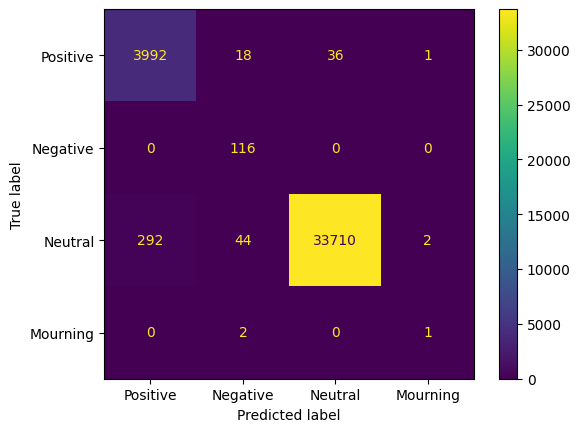

Accuracy:  0.9896634741194327
Precision:  0.9906928729173493
F1-Score:  0.989961238295044


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

predictions = lr_model.transform(test_df)
# Confusion matrix
actual = predictions.select("label").toPandas()
predicted = predictions.select("prediction").toPandas()

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Positive", "Negative", "Neutral", "Mourning"])

cm_display.plot()
plt.show()
# Finding accuracy
Accuracy = metrics.accuracy_score(actual, predicted)
print(f"Accuracy: ",Accuracy)
#Finding precision
Precision = metrics.precision_score(actual, predicted,average='weighted')
print(f"Precision: ",Precision)
#finding f-score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1-Score: ",f1_score)


## Mapping Predictions Back to Sentiment Labels


In [ ]:
def label_to_sentiment(label):
    reverse_mapping = {0: "Positive", 1: "Negative", 2: "Neutral", 3: "Mourning"}
    return reverse_mapping.get(label, "Unknown")

label_udf = udf(label_to_sentiment, StringType())
predictions = predictions.withColumn("predicted_sentiment", label_udf(col("prediction")))
predictions.select("filteredWords", "sentiment", "predicted_sentiment").show(30, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------------+
|filteredWords                                                                                                                                                                                                                                                                                                |sentiment|predicted_sentiment|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------------